In [1]:
import pandas as pd
import os
from os.path import join
import numpy as np
import mne
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)

import h5py
from os.path import join as opj
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import tqdm
from versatile_diffusion_dual_guided_fake_images import *

from torchsummary import summary

import pandas as pd
import os
from os.path import join as opj
from PIL import Image
import h5py
import numpy as np
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#import labelencoder
from sklearn.preprocessing import LabelEncoder
#import pipeline
from sklearn.pipeline import Pipeline
import tqdm
import torchvision

/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class NSDDataset(Dataset):
    

    
    def __init__(self, fmri_data,imgs_data,caption_data,transforms=None):
        self.fmri_data=np.load(fmri_data)
        self.imgs_data=np.load(imgs_data).astype(np.uint8)
        self.caption_data=np.load(caption_data,allow_pickle=True)
        self.transforms=transforms
        
    def __len__(self):
        return  len(self.fmri_data)
    
    def __getitem__(self,idx):
        fmri=torch.tensor(self.fmri_data[idx])
        img=Image.fromarray(self.imgs_data[idx])
        
        if self.transforms:
            img=self.transforms(img)
        
        caption=self.caption_data[idx][0] #cambiare se ne voglio altre
        
        return fmri,img,caption
                       

In [3]:
def get_dataset(sub):
    base_path="/home/matteo/brain-diffuser/data"
    timeseries_path=opj(base_path,"nsddata_timeseries")
    betas_path=opj(base_path,"nsddata_betas")

    stimuli_path=opj(base_path,"nsddata_stimuli","stimuli","nsd")
    stim_file_path=opj(stimuli_path,"nsd_stimuli.hdf5")
    mod="func1pt8mm"
    subj_data_path=opj(timeseries_path,"ppdata",sub,mod,"timeseries")
    subj_betas_path=opj(betas_path,"ppdata",sub,mod,"betas_assumehrf")

    subj_betas_roi_extracted_path=opj(base_path,"processed_roi",sub,mod)

    stim_order_path=opj(base_path,"nsddata","experiments","nsd","nsd_expdesign.mat")
    stim_info_path=opj(base_path,"nsddata","experiments","nsd","nsd_stim_info_merged.csv")
    stim_captions_train_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_train2017.json")
    stim_captions_val_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_val2017.json")

    processed_data=opj(base_path,"processed_data",sub)

    sub_idx=int(sub.split("0")[-1])

    fmri_train_data=opj(processed_data,f"nsd_train_fmriavg_nsdgeneral_sub{sub_idx}.npy")
    imgs_train_data=opj(processed_data,f"nsd_train_stim_sub{sub_idx}.npy")
    captions_train_data=opj(processed_data, f"nsd_train_cap_sub{sub_idx}.npy")

    fmri_test_data=opj(processed_data,f"nsd_test_fmriavg_nsdgeneral_sub{sub_idx}.npy")
    imgs_test_data=opj(processed_data,f"nsd_test_stim_sub{sub_idx}.npy")
    captions_test_data=opj(processed_data, f"nsd_test_cap_sub{sub_idx}.npy")



    tr=torchvision.transforms.ToTensor()
    train_dataset=NSDDataset(fmri_train_data,imgs_train_data,captions_train_data,transforms=tr)
    test_dataset=NSDDataset(fmri_test_data,imgs_test_data,captions_test_data,transforms=tr)


    BS=32

    train_dataloader=DataLoader(train_dataset,BS,shuffle=False)
    # val_dataloader=DataLoader(val_dataset,BS,shuffle=True)
    test_dataloader=DataLoader(test_dataset,BS,shuffle=False)



    to_pil= torchvision.transforms.ToPILImage()

    train_clip_img_embeds=[]
    train_fmri_data=[]
    train_imgs=[]
    with torch.no_grad():
        for x,y,c in tqdm.tqdm(train_dataloader,position=0):

            #save img data

            images=[to_pil(i) for i in y]

            #encode images in CLIP
            image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
            train_clip_img_embeds.append(image_features)
            train_fmri_data.append(x)
            train_imgs.append(y)

        train_clip_img_embeds = torch.cat(train_clip_img_embeds,axis=0)
        train_fmri_data = torch.cat(train_fmri_data,0)
        train_imgs = torch.cat(train_imgs,0)


    test_clip_img_embeds=[]
    test_fmri_data=[]
    test_imgs=[]
    
    with torch.no_grad():
        for x,y,c in tqdm.tqdm(test_dataloader,position=0):

            #save img data

            images=[to_pil(i) for i in y]

            #encode images in CLIP
            image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
            test_clip_img_embeds.append(image_features)
            test_fmri_data.append(x)
            test_imgs.append(y)


        test_clip_img_embeds = torch.cat(test_clip_img_embeds,axis=0)
        test_fmri_data = torch.cat(test_fmri_data,0)
        test_imgs = torch.cat(test_imgs,0)
        
    #standardize data
    mean=train_fmri_data.mean(0)
    std = train_fmri_data.std(0)
    train_fmri_data = (train_fmri_data - mean)/std
    test_fmri_data = (test_fmri_data - mean)/std
    
    test_fmri_data = torch.nan_to_num(test_fmri_data)
    train_fmri_data = torch.nan_to_num(train_fmri_data)
    
        
    return train_fmri_data,test_fmri_data, train_imgs, test_imgs,train_clip_img_embeds, test_clip_img_embeds


In [4]:
batch=64
device="cuda:2"

pipe_embed = VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline.from_pretrained("shi-labs/versatile-diffusion", )

pipe_embed.remove_unused_weights()
pipe_embed = pipe_embed.to(device)

Fetching 17 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 150746.66it/s]


In [47]:
train_datas=[]
test_datas=[]
img_train=[]
img_test=[]
train_clip_img_embeds=[]
test_clip_img_embeds=[]
subject_train_ids=[]
subject_test_ids=[]

for p in tqdm.tqdm(["subj01","subj02","subj05","subj07"]):
    train_data_,test_data_, img_train_, img_test_,train_clip_img_embeds_, test_clip_img_embeds_=get_dataset(p)
    img_train.append(img_train_)
    img_test.append(img_test_)
    train_datas.append(train_data_)
    test_datas.append(test_data_)
    train_clip_img_embeds.append(train_clip_img_embeds_)
    test_clip_img_embeds.append(test_clip_img_embeds_)

    subject_train_ids+=[p]*len(train_data_)
    subject_test_ids+=[p]*len(test_data_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [17:36<00:00, 264.16s/it]


In [48]:
## LAVORARE QUI -> PAD FMRI DATA E SALVATAGGIO

# train_data=np.concatenate(train_datas)
# test_data=np.concatenate(test_datas)
max_cols = max(array.shape[1] for array in train_datas)
padded_train_datas = []
for array in train_datas:
    # Calculate padding needed for rows and columns
    pad_cols = max_cols - array.shape[1]

    # Apply padding (adding zeros)
    padded_array = np.pad(array, ((0, 0), (0, pad_cols)), mode='constant', constant_values=0)
    padded_train_datas.append(padded_array)

    
padded_test_datas = []
for array in test_datas:
    # Calculate padding needed for rows and columns
    pad_cols = max_cols - array.shape[1]

    # Apply padding (adding zeros)
    padded_array = np.pad(array, ((0, 0), (0, pad_cols)), mode='constant', constant_values=0)
    padded_test_datas.append(padded_array)

    
    

In [49]:
train_data=np.concatenate(padded_train_datas,0)
test_data=np.concatenate(padded_test_datas,0)

img_train=torch.cat(img_train,0)
img_test=torch.cat(img_test,0)

train_clip_img_embeds=torch.cat(train_clip_img_embeds,0)
test_clip_img_embeds=torch.cat(test_clip_img_embeds,0)


In [18]:
# torch.cat(train_clip_img_embeds,0).shape

torch.Size([35436, 257, 768])

In [20]:
# subject_train_ids

In [50]:
os.makedirs("data_fmri_nsd",exist_ok=True)

#save everything

np.save("data_fmri_nsd/train_data.npy",train_data)
np.save("data_fmri_nsd/test_data.npy",test_data)

torch.save(train_clip_img_embeds[:,0],"data_fmri_nsd/train_clip_img_embeds.pt")
torch.save(test_clip_img_embeds[:,0],"data_fmri_nsd/test_clip_img_embeds.pt")

# torch.save(img_train,"data_fmri_nsd/img_train.pt")
# torch.save(img_test,"data_fmri_nsd/img_test.pt")

np.save("data_fmri_nsd/subject_train_ids.npy",np.array(subject_train_ids))
np.save("data_fmri_nsd/subject_test_ids.npy",np.array(subject_test_ids))

#also images!


In [71]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim,act_fn=nn.ReLU,alignment_layers_keys=[1,2,5,7],common_dim=1024):
        super(Encoder, self).__init__()
        self.common_dim=common_dim
        self.alignment_layers={}
        for k in alignment_layers_keys:
            self.alignment_layers[k]=nn.LazyLinear(common_dim)
        
        
        layers = []
        prev_dim = input_dim
        if len(hidden_dims):

            for hidden_dim in hidden_dims:
                layers.append(nn.LazyLinear(hidden_dim))
                layers.append(act_fn())
            layers.append(nn.LazyLinear(output_dim))
            self.net = nn.Sequential(*layers)     
        else:
            self.net = nn.Linear(input_dim, output_dim)

        
    def _apply(self, fn):
        super(Encoder, self)._apply(fn)        
        for k,v in self.alignment_layers.items():
            self.alignment_layers[k]._apply(fn)
            
    
    def forward(self, x, k=None):
        
        def apply_alignment_layers(x, k, alignment_layers):
            # Create an empty tensor to store the results
            result = torch.empty_like(x)
            result = result[:,:self.common_dim]
            
            # Iterate through each unique key in k
            for key in k.unique():
                # Create a mask for all elements that match the current key
                mask = (k == key.item())
                
                # print(x.shape, result.shape, mask)
                
                # Apply the corresponding alignment layer to the masked elements
                result[mask] = alignment_layers[key.item()](x[mask])
            
            return result
        
        if k is None:
            k=torch.ones(len(x))
        # Apply alignment layers to x using the custom function
        x = apply_alignment_layers(x, k, self.alignment_layers)
        
        # x = self.alignment_layers[k](x)
        return self.net(x)

In [63]:
# torch.empty(100,10).shape

In [27]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class ContrastiveModel(pl.LightningModule):

    def contrastive_loss(self, z_i, z_j):

        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        logits = (z_i @ z_j.T) / self.temperature
        similarities = z_j @ z_j.T
        # targets = torch.nn.functional.softmax(similarities * self.temperature, dim=-1)

        targets = torch.arange(logits.shape[0]).long().to(logits.device)
        
        loss = torch.nn.functional.cross_entropy(logits, targets)
        return loss
    
    def mean_contrastive(self, z_i, z_j, temperature=1.0):
        return nn.functional.mse_loss(z_i, z_j)+self.contrastive_loss(z_i, z_j, temperature=temperature)/8
    
    def cosine_loss(self, z_i, z_j, temperature=1.0):
        cosine_similarity = torch.nn.functional.cosine_similarity(z_i, z_j).mean()
        return 1- cosine_similarity

    def __init__(self,  num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU, temperature=.1,loss_type="contrastive"):
        super().__init__()
        
        self.temperature=temperature
        
        self.model = Encoder(num_input_channels, base_channel_size, latent_dim, act_fn)

        self.loss_type=loss_type
        if loss_type=="contrastive":
            self.loss_fn=self.contrastive_loss
        elif loss_type=="mean_contrastive":
            self.loss_fn=self.mean_contrastive
        
        elif loss_type=="mse":
            self.loss_fn=torch.nn.functional.mse_loss
        elif loss_type=="cosine":
            self.loss_fn=self.cosine_loss
        
        self.train_losses = []
        self.train_mse=[]
        self.train_cosine=[]
        self.val_losses = []
        self.val_mse=[]
        self.val_cosine=[]
    
        self.train_history={}
        self.val_history={}

        #init history
        self.train_history["train_loss"]=[]
        self.train_history["train_mse"]=[]
        self.train_history["train_cosine"]=[]
        self.val_history["val_loss"]=[]
        self.val_history["val_mse"]=[]
        self.val_history["val_cosine"]=[]


    def forward(self, x, **kwargs):
        return self.model(x,**kwargs)
    
    def training_step(self, batch, batch_idx):
        x, y,idx= batch
        # x = x.float()
        y_hat = self(x,k=idx)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.train_losses.append(loss.item())

        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.train_mse.append(mse_loss.item())
        self.train_cosine.append(cosine_similarity.item())

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        
        x, y, idx= batch
        # x = x.float()

        y_hat = self(x,k=idx)

        loss=self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        
        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log('val_mse_loss', mse_loss, on_epoch=True, prog_bar=True)
        
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.log('val_cosine_similarity', cosine_similarity, on_epoch=True, prog_bar=True)
        
        self.val_losses.append(loss.item())
        self.val_mse.append(mse_loss.item())
        self.val_cosine.append(cosine_similarity.item())
        return mse_loss
        
    
    def on_train_epoch_end(self) -> None:
        self.train_history["train_loss"].append(np.mean(self.train_losses))
        self.train_history["train_mse"].append(np.mean(self.train_mse))
        self.train_history["train_cosine"].append(np.mean(self.train_cosine))
        self.train_losses = []
        self.train_mse=[]
        self.train_cosine=[]
        return super().on_train_epoch_end()
    
    def on_validation_epoch_end(self) -> None:
        self.val_history["val_loss"].append(np.mean(self.val_losses))
        self.val_history["val_mse"].append(np.mean(self.val_mse))
        self.val_history["val_cosine"].append(np.mean(self.val_cosine))
        self.val_losses = []

        self.val_mse=[]
        self.val_cosine=[]
        return super().on_validation_epoch_end()

        
    def configure_optimizers(self):
        # return torch.optim.AdamW(self.parameters(), lr=3e-4, weight_decay=0)
        # add a scheduler
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        # use a scheduler that every 100 steps, it will reduce the learning rate by 0.1
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}



In [51]:
subject_train_ids=[int(i[-1]) for i in subject_train_ids]
subject_test_ids=[int(i[-1]) for i in subject_test_ids]


In [57]:

# summary(brain_model, (train_data.shape[1],),device="cpu")

/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [53]:
train_data.shape, train_clip_img_embeds.shape, test_data.shape, test_clip_img_embeds.shape

((35436, 15724),
 torch.Size([35436, 257, 768]),
 (3928, 15724),
 torch.Size([3928, 257, 768]))

In [54]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(),train_clip_img_embeds[:,0], torch.tensor(subject_train_ids))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(),test_clip_img_embeds[:,0], torch.tensor(subject_test_ids))

x,y,idx=train_dataset[0]    



BS=256

clip_train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
clip_test_dataloader=DataLoader(test_dataset, batch_size=BS, shuffle=False)

x.shape, y.shape

(torch.Size([15724]), torch.Size([768]))

In [72]:
brain_model = ContrastiveModel(num_input_channels= train_data.shape[-1], base_channel_size=[768], latent_dim=768,act_fn=nn.ReLU, loss_type="contrastive")

# Instantiate a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=20, devices=[1])

# Train the model
trainer.fit(brain_model, clip_train_dataloader, clip_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type    | Params
----------------------------------
0 | model | Encoder | 0     
----------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 80.11it/s, v_num=15, train_loss_step=3.830]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████| 139/139 [00:01<00:00, 73.93it/s, v_num=15, train_loss_step=3.830, val_loss=4.630, val_mse_loss=0.0214, val_cosine_similarity=0.128]
Epoch 1: 100%|█| 139/139 [00:01<00:00, 74.23it/s, v_num=15, train_loss_step=3.440, val_loss=4.630, val_mse_loss=0.0214, val_cosine_similarity=0.128, train_loss_epoch=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 15/16 [00:00<00:00, 120.84it/s]
Epoch 1: 100%|█| 139/139 [00:02<00:00, 69.05it/s, v_num=15, train_loss_step=3.440, val_loss=4.360, val_mse_loss=0.025, val_cosine_similarity=0.172, train_loss_epoch=5
Epoch 2: 100%|█| 139/139 [00:01<00:00, 79.58it/s, v_num=15, train_loss_step=3.440, val_loss=4.360, val_

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 139/139 [00:01<00:00, 75.97it/s, v_num=15, train_loss_step=2.270, val_loss=4.030, val_mse_loss=0.0115, val_cosine_similarity=0.217, train_loss_epoch


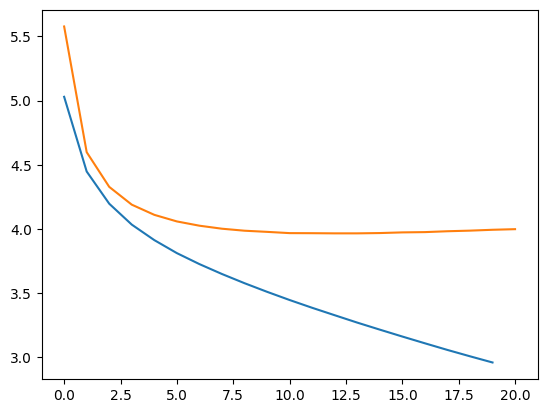

In [73]:
plt.plot(brain_model.train_history["train_loss"], label='train')
plt.plot(brain_model.val_history["val_loss"], label='val')

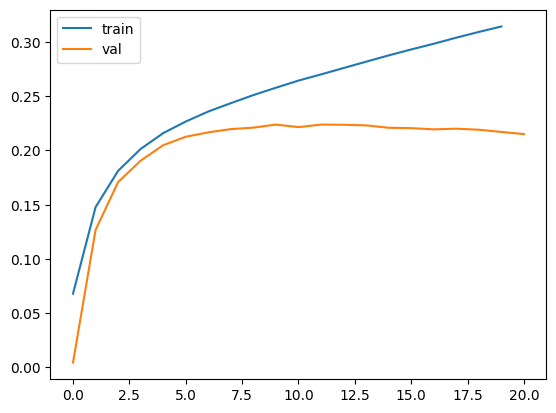

In [74]:
plt.plot(brain_model.train_history["train_cosine"], label='train')
plt.plot(brain_model.val_history["val_cosine"], label='val')

plt.legend()

In [76]:
x,y,k=next(iter(clip_test_dataloader))

y_pred=[]
with torch.no_grad():

    for x,y,k in tqdm.tqdm(clip_test_dataloader):
        y_hat=brain_model(x,k=k).cpu()
        y_pred.append(y_hat)

y_pred=torch.cat(y_pred,0)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.84it/s]


In [88]:
# top_indices

In [89]:
# similarity=  torch.nn.functional.softmax(.1*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred,.1).T)

z_i=y_pred
z_j=test_clip_img_embeds[:982,0]

z_i = nn.functional.normalize(z_i, dim=1)
z_j = nn.functional.normalize(z_j, dim=1)

logits = (z_i @ z_j.T) / .1

similarity =  torch.nn.functional.softmax(logits,-1)
top_indices=torch.topk(similarity,500,1).indices
# similarity=  torch.nn.functional.softmax(10*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred.T,-1))

In [90]:
## voglio selezionare immagini diverse!
selected_images=[]
for top_idxs in tqdm.tqdm(top_indices,position=0):
    selected_images.append(img_test[top_idxs[:5]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3928/3928 [00:02<00:00, 1610.93it/s]


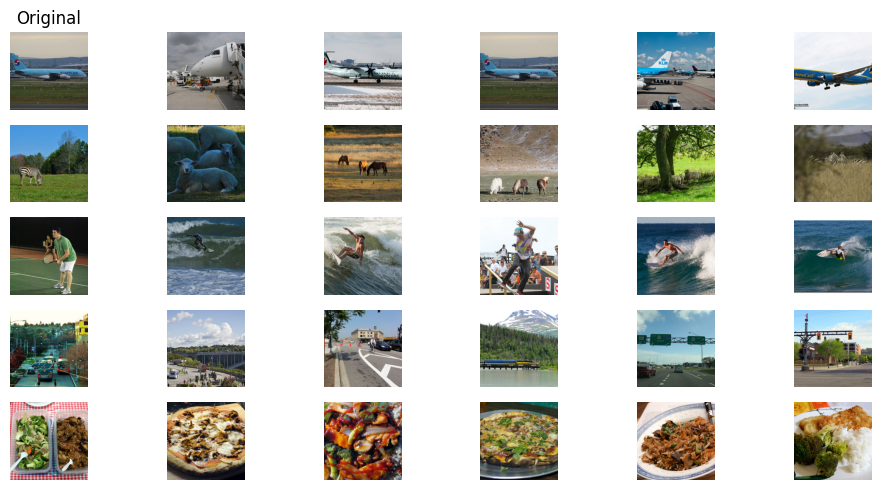

In [97]:
idx=25
fig, ax = plt.subplots(5,6,figsize=(10,5))  


for i in range(5):
    ax[i,0].imshow(img_test[idx+i].permute(1,2,0))
    ax[i,1].imshow(selected_images[idx+i][0].permute(1,2,0))

    ax[i,2].imshow(selected_images[idx+i][1].permute(1,2,0))
    ax[i,3].imshow(selected_images[idx+i][2].permute(1,2,0))
    ax[i,4].imshow(selected_images[idx+i][3].permute(1,2,0))

    ax[i,5].imshow(selected_images[idx+i][4].permute(1,2,0))

    ax[i,0].axis("off")
    ax[i,1].axis("off")
    ax[i,2].axis("off")
    ax[i,3].axis("off")
    ax[i,4].axis("off")
    ax[i,5].axis("off")

ax[0,0].set_title("Original")   


plt.tight_layout()


In [95]:
os.makedirs(f"models_contrastive_fMRI_NSD_all",exist_ok=True)

torch.save(brain_model, "models_contrastive_fMRI_NSD_all/whole_pl_model.pt")
torch.save(brain_model.state_dict(), "models_contrastive_fMRI_NSD_all/whole_pl_model_state_dict.pt")

torch.save(brain_model.model, "models_contrastive_fMRI_NSD_all/encoder.pt")
torch.save(brain_model.model.state_dict(), "models_contrastive_fMRI_NSD_all/encoder_state_dict.pt")


In [101]:
## check
#save individually all keys
for k in brain_model.model.alignment_layers.keys():
    torch.save(brain_model.model.alignment_layers[k].state_dict(),f"models_contrastive_fMRI_NSD_all/alignment_layers_{k}_state_dict.pt")

In [2]:
# print("Ok")